In [143]:
# Importing the required libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import hvplot
import hvplot.pandas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pathlib import Path
from pystreamlit import InsiderDataFrame

#Supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [144]:
stock="GOOG"

In [145]:
#instantiate insider class
insider = InsiderDataFrame("insider_data_v2.csv")

# Instantiate the Insider Class
stock_df = insider.get_processed_df(stock) 

# Droping any null values due to filing date being on a non trading day.
stock_df = stock_df.dropna()


<class 'pandas.core.frame.DataFrame'>
Index: 1509 entries, 2023-06-05 to 2019-07-02
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1509 non-null   object 
 1   Price   1509 non-null   float64
 2   Qty     1509 non-null   int64  
 3   Owned   1509 non-null   int64  
 4   ΔOwn    1509 non-null   int64  
 5   Value   1509 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 82.5+ KB


In [146]:
def logistic_regression_model(stock_df):
    # Import modules for Logistic Regression
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Create X, or features DataFrame
    features = stock_df[['Price','Price','Qty','Value',"Owned","ΔOwn",'ClosePrice']]

    # Create y, or target DataFrame
    target = stock_df['Trend']

    # Use train_test_split to separate the data
    training_features, testing_features, training_targets, testing_targets = train_test_split(features, target, test_size=.3,random_state=7)


    #Scale the data
    scaler = StandardScaler()
    X_scaler = scaler.fit(training_features)
    training_features_scaled = X_scaler.transform(training_features)
    testing_features_scaled = X_scaler.transform(testing_features)

    #Instantiate a model
    logistic_regression_model = LogisticRegression(max_iter=1000,random_state=7)

    # Fit the model
    logistic_regression_model.fit(training_features_scaled, training_targets)


    # Generate predictions from the model we just fit
    predictions = logistic_regression_model.predict(training_features_scaled)

    # Convert those predictions (and actual values) to a DataFrame
    results_df = pd.DataFrame({"Prediction": predictions, "Actual": training_targets})

    # Apply the fitted model to the test dataset
    testing_predictions = logistic_regression_model.predict(testing_features_scaled)

    # Save both the test predictions and actual test values to a DataFrame
    results_df = pd.DataFrame({
    "Testing Data Predictions": testing_predictions,
    "Testing Data Actual Targets": testing_targets})

    #Print the confusion matrix for training data
    training_matrix = confusion_matrix(training_targets, predictions)
    print("Confusion matrix for training data")
    print(training_matrix)
    # Plot the confusion matrix for Training data
    cmd = ConfusionMatrixDisplay(training_matrix)  
    cmd.plot()

    #Print the confusion matrix for testing data
    testing_matrix = confusion_matrix(testing_targets, testing_predictions)
    print("Confusion matrix for testing data")
    print(testing_matrix)
    # Print the confusion matrix for Testing data
    cmd = ConfusionMatrixDisplay(testing_matrix)  
    cmd.plot()

    # Classification report for training data
    training_report = classification_report(training_targets, predictions)
    # Then view its output
    print("---Classification report for training data----")
    print(training_report)

    # Classification report for training data
    testing_report = classification_report(testing_targets, testing_predictions)
    # Then view its output
    print("---Classification report for testing data----")
    print(testing_report)   

Confusion matrix for training data
[[142  21]
 [ 76  36]]
Confusion matrix for testing data
[[54 10]
 [40 15]]
---Classification report for training data----
              precision    recall  f1-score   support

        -1.0       0.65      0.87      0.75       163
         1.0       0.63      0.32      0.43       112

    accuracy                           0.65       275
   macro avg       0.64      0.60      0.59       275
weighted avg       0.64      0.65      0.62       275

---Classification report for testing data----
              precision    recall  f1-score   support

        -1.0       0.57      0.84      0.68        64
         1.0       0.60      0.27      0.37        55

    accuracy                           0.58       119
   macro avg       0.59      0.56      0.53       119
weighted avg       0.59      0.58      0.54       119



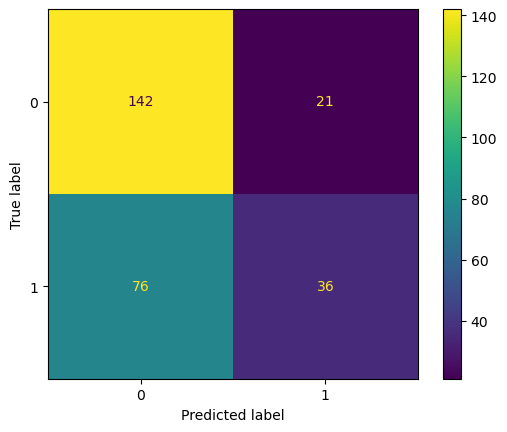

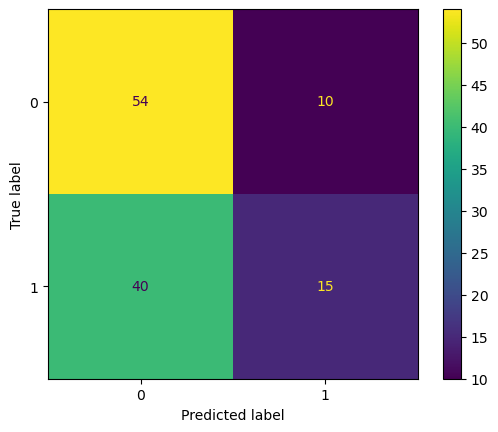

In [147]:
# Calling the Logistic Regression Model
logistic_regression_model(stock_df)

In [148]:

# Create charts for the stocks insider trading.
def create_charts():
    # Create a chart that shows all the insider trades for the stock
    stock_scatter_plot = stock_df.hvplot.scatter(y="Value",title=f"Insider Trades for {stock} by Date", ylabel="Value of Trades",rot=90, cmap="plasma").opts(yformatter='$%.0f')

    # Create a chart that shows the closing price on the insider trading days

    stock_insider_trades_plot = stock_df.hvplot.scatter(y="ClosePrice", color="orange", title=f"{stock} Insider Trades by Price", ylabel="Stock Price",rot=45, width=1000).opts(yformatter='$%.0f')
    
    # Create a chart to show the stock price overtime
    stock_price_df  = insider.df_tickers
    stock_price_df  = stock_price_df[stock].loc[pd.Timestamp(insider.fromdate):pd.Timestamp(insider.todate)]
    stock_price_plot = stock_price_df.hvplot(color="blue", title=f"{stock} Insider Trades and Stock Price", ylabel="Closing Price",rot=45, width=1000).opts(yformatter='$%.0f')

    #Overlay the stock price and the insider trading data
    overlay_stock_Plot = stock_price_plot * stock_insider_trades_plot


    #Visualize the signals

    # Visualize exit position relative to close price
    exit = stock_df[stock_df['Trend'] == -1.0]['ClosePrice'].hvplot.scatter(
        color='orange',
        marker='v',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize entry position relative to close price
    entry = stock_df[stock_df['Trend'] == 1.0]['ClosePrice'].hvplot.scatter(
        color='purple',
        marker='^',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize close price for the investment

    stock_price_df = insider.df_tickers[stock]

    security_close = stock_price_df.hvplot(
        line_color='grey',
        ylabel='Price in $',
        width=1000,
        height=400
    )


    # Create the overlay plot
    entry_exit_plot = security_close * entry * exit

    # Show the plot
    entry_exit_plot.opts(
        title=f"{stock} Entry and Exit Points and Price Movement"
)


    #Display the charts
    display(stock_scatter_plot)
    display(overlay_stock_Plot)
    display(entry_exit_plot)
   


In [149]:
# Create the charts for the stocks and trades for the stock
create_charts()

:Scatter   [index]   (Value)

:Overlay
   .Curve.GOOG :Curve   [index]   (GOOG)
   .Scatter.I  :Scatter   [index]   (ClosePrice)

:Overlay
   .Curve.GOOG            :Curve   [index]   (GOOG)
   .Scatter.ClosePrice.I  :Scatter   [index]   (ClosePrice)
   .Scatter.ClosePrice.II :Scatter   [index]   (ClosePrice)

In [150]:
def SVM_model(stock_df):

    # Get the Data ready for running the model

    # Import modules for Logistic Regression
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    from sklearn.metrics import classification_report, ConfusionMatrixDisplay
    from pandas.tseries.offsets import DateOffset
    import datetime as dt
    from sklearn import svm

    stock_df = stock_df.sort_index(ascending=True)

    # Create the X for testing
    X = stock_df[['Price','Price','Qty','Value',"Owned","ΔOwn",'ClosePrice']].dropna().copy()


    y = stock_df['Trend'].copy()

    # Select the start of the training period
    training_begin = X.index.min() 

    # Select the ending period for the training data with an offset of 3 months
    training_end =  (X.index.min() + DateOffset(months=30)).date()


    # Generate the X_train and y_train DataFrames
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]
        

    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]


    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end:]
    y_test = y.loc[training_end:]

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Apply the scaler model to fit the X_train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)  

    # Create the classifier model
    svm_model = svm.SVC()

    # Fit the model to the data using X_train_scaled and y_train
    svm_model = svm_model.fit(X_train_scaled, y_train)

    # Use the trained model to predict the trading signals for the training data
    testing_signal_predictions = svm_model.predict(X_test_scaled)

    # Use the trained model to predict the trading signals for the training data
    training_signal_predictions = svm_model.predict(X_train_scaled)

    # Display the sample predictions
    training_signal_predictions[:10]

    #Evaluate the model using a classification report - Testing
    training_report = classification_report(y_test, testing_signal_predictions)
    print("---Classification report for testing data----")
    print(training_report)

    # Evaluate the model using a classification report - Training
    training_report = classification_report(y_train, training_signal_predictions)
    print("---Classification report for training data---")
    print(training_report)

In [151]:
# Calling the SVM  Model
SVM_model(stock_df)

---Classification report for testing data----
              precision    recall  f1-score   support

        -1.0       0.54      0.99      0.70        68
         1.0       0.91      0.15      0.26        67

    accuracy                           0.57       135
   macro avg       0.72      0.57      0.48       135
weighted avg       0.72      0.57      0.48       135

---Classification report for training data---
              precision    recall  f1-score   support

        -1.0       0.64      0.99      0.78       159
         1.0       0.87      0.13      0.23       100

    accuracy                           0.66       259
   macro avg       0.76      0.56      0.50       259
weighted avg       0.73      0.66      0.57       259

